In [65]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error

In [23]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,1.0,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,1.0,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00


In [24]:
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [25]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [26]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333


In [27]:
df.shape

(56551, 21)

In [28]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    56551.000000
mean        18.171379
std         75.464751
min          0.000000
50%         11.400000
95%         33.683333
98%         46.816667
99%         59.825000
max       1438.983333
Name: duration, dtype: float64

In [31]:
df = df[((df.duration >= 1) & (df.duration <= 60))]

In [32]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333


In [34]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [37]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [38]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [39]:
y_train = df['duration'].values

In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [43]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_19331/573422158.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='Prediction')
/tmp/ipykernel_19331/573422158.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='Actual')


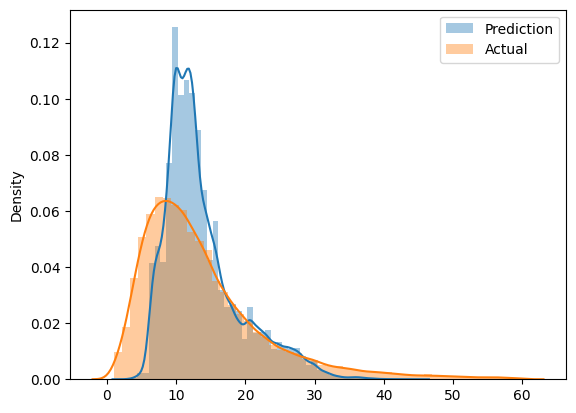

In [46]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')
plt.legend()

In [51]:
root_mean_squared_error(y_train, y_pred)

7.1228220948023795

In [52]:
def read_dataframe(file_path):
    df = pd.read_parquet(file_path)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[((df.duration >= 1) & (df.duration <= 60))]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [53]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')

In [54]:
df_train.shape, df_val.shape

((54373, 21), (51497, 21))

In [61]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [62]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [56]:
y_train = df_train['duration'].values
y_val = df_val['duration'].values

In [63]:
# baseline model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

5.9947992164797

In [64]:
# lasso
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_val)
root_mean_squared_error(y_val, y_pred)

6.008120318390882

In [66]:
# save the model
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)